In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install nltk
!pip install scikit-learn
!python -m spacy download en_core_web_lg
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-05 13:10:55.625450: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Foun

#Импортируем нужные библиотеки

In [ ]:
import pandas as pd
import numpy as np
import heapq
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
import nltk
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn import naive_bayes, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Создаем датафрейм и просматриваем его первые строки

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train_data.csv')
train_df.head()

,Unnamed: 0,publication_number,abstract,application_number,description,label
0,0,US-4922184-A,an apparatus for simultaneously testing multip...,US-23743888-A,"turning now to the drawings , there is shown i...",Physics
1,1,US-2016074097-A1,an electrosurgical instrument includes a housi...,US-201514798016-A,deployment mechanisms that are configured for ...,Human Necessities
2,2,US-2011188479-A1,a wireless transceiver device employing the co...,US-201113029256-A,"now , first and second embodiments of the pres...",Electricity
3,3,US-2013165453-A1,the invention provides for the use of protein ...,US-201213553565-A,"as used herein , “ administration ” of a compo...",Human Necessities
4,4,US-2008267006-A1,the present invention relates to a device for ...,US-65947604-A,"in accordance with the figures , the mixing de...",General tagging of new or cross-sectional tech...


# Классы не сбалансированны

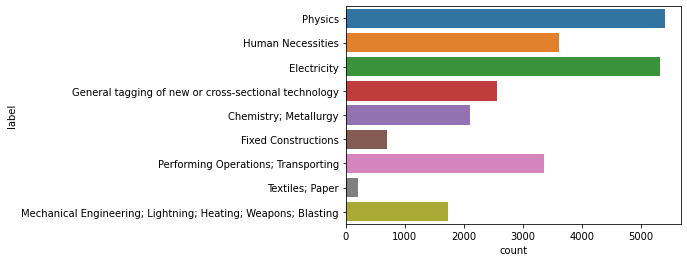

In [ ]:
sns.countplot(y = train_df['label'])

# Балансировка классов

In [ ]:
topics = ['Human Necessities', 'Performing Operations; Transporting', 'Chemistry; Metallurgy',
          'Physics', 'Electricity'] #'Textiles; Paper', 'Fixed Constructions' 'Mechanical Engineering; Lightning; Heating; Weapons; Blasting', 'General tagging of new or cross-sectional technology',

In [ ]:
df_res = pd.DataFrame()

for topic in topics:
    df_topic = train_df[train_df['label'] == topic][:3000]
    df_res = df_res.append(df_topic, ignore_index=True)

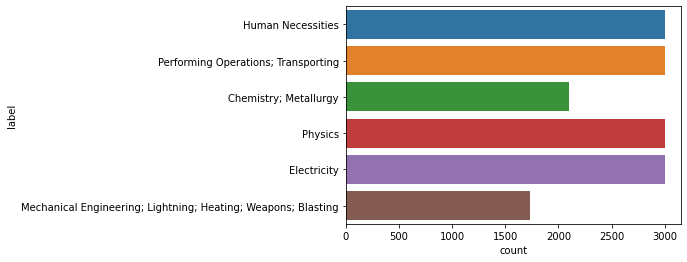

In [ ]:
 sns.countplot(y = df_res['label'])

# Сходство текстов

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
def dependency_parsing(row):
  doc = nlp(row) # SpaCy делает магию
  tokens = [] # Инициализируем список, в котором будут храниться нужные нам токены
  for token in doc:
    if token.dep_ in ('nsubj', 'ROOT', 'dobj'): # Проверка является ли токен объектом, субъектом или глаголом связывающим их
      tokens.append(token.lemma_.lower()) # Подставляем лемму подходящего токекна в нижнем регистре
  return ' '.join(tokens)

In [ ]:
%%time
clean_df = df_res['abstract'].apply(lambda x: dependency_parsing(x))

CPU times: user 5min 24s, sys: 827 ms, total: 5min 25s
Wall time: 5min 28s


In [ ]:
def similarity(text1, text2):
  doc1, doc2 = nlp(text1), nlp(text2)
  return doc1.similarity(doc2)

In [ ]:
def find_most_most_similar(text, df):
  highest_score = 0
  index = 0
  for i, doc in enumerate(df):
    similarity_score = similarity(text, doc)
    if highest_score < similarity_score:
      highest_score = similarity_score
      index = i
  return [doc, index, highest_score]

In [ ]:
%%time
result = find_most_most_similar('the voltage drop across the test circuit exceeds the threshold voltage of the differential amplifier', clean_df)

<ipython-input-13-a11833d886f5>:3: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc1.similarity(doc2)


CPU times: user 3min 40s, sys: 663 ms, total: 3min 40s
Wall time: 3min 42s


In [ ]:
print(result[0])
print(df_res['abstract'][result[1]])
print(result[2])

noise present connect office convert signal encode structure which determination
an x - ray computer tomography apparatus comprises a high - voltage transformer which performs the increase and noncontacting transmission of the power simultaneously and outputs a desired high voltage for causing x rays to be generated at the rotatable gantry section . the high - voltage transformer is divided into a primary - side which is provided on the static gantry section and to which the output of a frequency converting circuit is supplied and a secondary - side which generates a high voltage . a capacitor is connected to a secondary coil of the high - voltage transformer , thereby forming a resonance circuit .


In [ ]:
# %%time
# newdf = df_res['abstract'].apply(lambda x: ' '.join([i.lemma_.lower() for i in nlp(x) if i.dep_ in ('nsubj', 'ROOT', 'dobj')]))

CPU times: user 5min 45s, sys: 895 ms, total: 5min 45s
Wall time: 5min 49s


# Инициализируем токенизатор из библиотеки NLTK, который токенезирует слова с помощью регулярного выражения

In [ ]:
tokenizer = RegexpTokenizer(r'\b([a-z]+)\b')

# Объявляем лемматизатор из библиотеки NLTK

In [ ]:
lemmatizer = WordNetLemmatizer()

# Создаем функцию, которая возвращает определенную часть речи, для того, чтобы лемматизатор более точно лемматизировал слово


In [ ]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Создаем функцию для предпотготовки текста



In [ ]:
def preprocess_tokenize(row):
  lowered_row = row.lower() # Переводим в нижний регистр все слова в строке
  tokens = tokenizer.tokenize(remove_stopwords(lowered_row)) # Убираем стоп слова и токенизируем строку
  filtered_tokens = []
  for token in tokens: # Осоновываясь на части речи производим лемматизацию                
    postag = get_wordnet_pos(pos_tag([token])[0][1])
    if postag == None:
      lem = lemmatizer.lemmatize(token)
      if len(lem) > 1: # Не используем слово, если его длина меньше двух символов
        filtered_tokens.append(lem)
    else:
      lem = lemmatizer.lemmatize(token, postag)
      if len(lem) > 1:
        filtered_tokens.append(lem)
  return(filtered_tokens)

# Пример преодобработки текста


In [ ]:
train_df['abstract'][3]

'the invention provides for the use of protein kinase activators or boosters of nerve growth factor , brain - derived neurotrophic factor or other neurotrophic factors to treat stroke . specifically , the present invention provides methods of treating stroke comprising the steps of identifying a subject having suffered a stroke and administering to said subject an amount of a pharmaceutical composition comprising a protein kinase c activator or 4 - methylcatechol acetic acid and a pharmaceutically acceptable carrier effective to treat at least one symptom of stroke .'

In [ ]:
print(preprocess_tokenize(train_df['abstract'][3]))

['invention', 'provide', 'use', 'protein', 'kinase', 'activator', 'booster', 'nerve', 'growth', 'factor', 'brain', 'derive', 'neurotrophic', 'factor', 'neurotrophic', 'factor', 'treat', 'stroke', 'specifically', 'present', 'invention', 'provide', 'method', 'treat', 'stroke', 'comprise', 'step', 'identify', 'subject', 'have', 'suffer', 'stroke', 'administer', 'say', 'subject', 'pharmaceutical', 'composition', 'comprise', 'protein', 'kinase', 'activator', 'methylcatechol', 'acetic', 'acid', 'pharmaceutically', 'acceptable', 'carrier', 'effective', 'treat', 'symptom', 'stroke']


# Векторизируем текст с помощью частотной модели TF-IDF

In [ ]:
%%time
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, lowercase = False, tokenizer = preprocess_tokenize,
                             max_df = 1.0, ngram_range = (1, 3), max_features=10000)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_res['abstract'])
tfidf_2d_array = tfidf_matrix.toarray()

CPU times: user 2min 53s, sys: 7.94 s, total: 3min 1s
Wall time: 3min 5s


# Оценка работы частотной модели TF-IDF

In [ ]:
def avg_tfidf(tfidf_2d_array):

  row_len = len(tfidf_2d_array[0])
  sum_of_tfidfs, word_accurance = [0.0] * row_len, [0] * row_len
  wordlist = tfidf_vectorizer.get_feature_names_out()

  for row in range(len(tfidf_2d_array)):
    for element in range(row_len):
      if tfidf_2d_array[row][element] != 0.0:
        word_accurance[element] += 1
        sum_of_tfidfs[element] += tfidf_2d_array[row][element]

  avg_word_tfidf = []
  for x, y in zip(sum_of_tfidfs, word_accurance):
      if y != 0:
        avg_word_tfidf.append(x/y)
      else:
        avg_word_tfidf.append(0)

  avg_tfidf_word_dict = dict(zip(wordlist, avg_word_tfidf))
    
  return avg_tfidf_word_dict

In [ ]:
%%time
total_avg_tfidf = avg_tfidf(tfidf_2d_array)

CPU times: user 51.2 s, sys: 0 ns, total: 51.2 s
Wall time: 51.7 s


Средняя важность слова во всем корпусе текстов

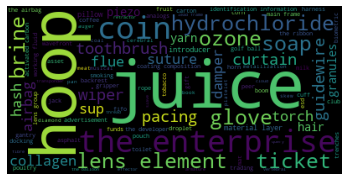

In [ ]:
wordcloud = WordCloud(max_words = 100).fit_words(total_avg_tfidf)
plt.axis("off")
plt.imshow(wordcloud)

Топ 5 важных слов в каждом классе

In [ ]:
%%time
for topic in topics:
  tfidf_2darray_class = []
  for vector, label in zip(tfidf_2d_array, df_res['label'].tolist()):
    if label == topic:
      tfidf_2darray_class.append(vector)

  avg_tfidf_word_dict_class = avg_tfidf(tfidf_2darray_class)
  top_words = heapq.nlargest(15, avg_tfidf_word_dict_class, key=avg_tfidf_word_dict_class.get)
  
  print(topic + ':', end= ' ')
  print(*top_words, sep=', ')

Human Necessities: shoelace, lace, chart, stretcher, mop, headlamp, weapon, slat, curtain, metal oxide, proanthocyanidin, latex, camptothecin, rice, test medium
Performing Operations; Transporting: merchandise, broach, exterior component, appendage, reline, storage element, canal, bitumen, note, mower, thermoelectric, strainer, barge, plurality device, raceway
Chemistry; Metallurgy: infant, canister, lid, cell body, distinctive, mold member, maltose, scrub, macro, cryogen, base body, interferon, effervescent, cane, nitride semiconductor
Physics: puncture, sprite, hoop, seeker, footwear, conference, beacon, wellbore, pb, registrant, mosfet, rental, splice, page size, cotton
Electricity: tenant, firewall, lock portion, machinery, object area, inflatable, checksum, shrink, mtc, exchangeable, sr, reflectance, coin, pixel data, wire harness
Mechanical Engineering; Lightning; Heating; Weapons; Blasting: skate, ventilator, kite, drive apparatus, power conversion, flexible member, electrical c

# Разделяем данные на обучение и тест

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, df_res['label'], train_size=0.7)

# Классифицируем текст с помощью метода опорных векторов

In [ ]:
SVM = svm.LinearSVC(max_iter = 10000)
SVM.fit(x_train,y_train)
print('Точность при обучении: ', SVM.score(x_train, y_train))
svm_predictions = SVM.predict(x_test)
print(precision_score(y_test, svm_predictions, average="macro"))
print(recall_score(y_test, svm_predictions, average="macro"))
print(f1_score(y_test, svm_predictions, average="macro"))
print()
print(classification_report(svm_predictions, y_test, target_names=topics))

Точность при обучении:  0.976985559566787
0.6775896772403139
0.680001868923179
0.678447164027288

                                                               precision    recall  f1-score   support

                                            Human Necessities       0.73      0.72      0.72       627
                          Performing Operations; Transporting       0.72      0.70      0.71       922
                                        Chemistry; Metallurgy       0.68      0.73      0.70       851
                                                      Physics       0.68      0.64      0.66       517
                                                  Electricity       0.63      0.64      0.63       906
Mechanical Engineering; Lightning; Heating; Weapons; Blasting       0.65      0.63      0.64       926

                                                     accuracy                           0.68      4749
                                                    macro avg       0.68    

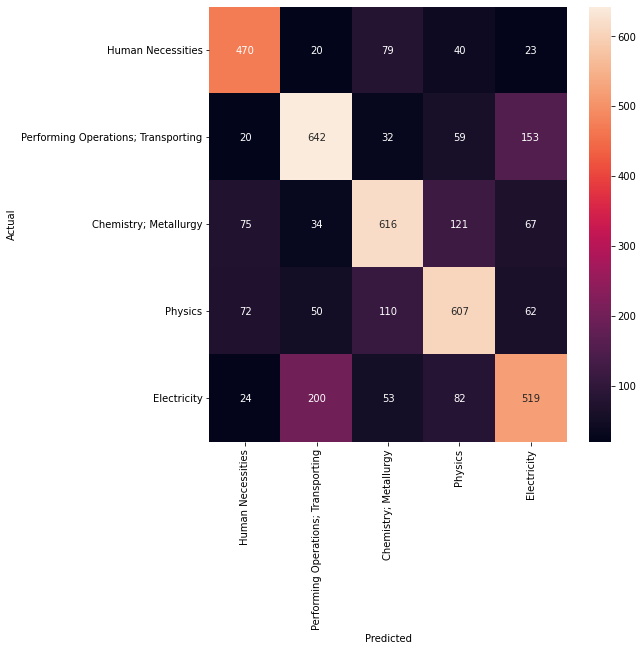

In [ ]:
conf_mat = confusion_matrix(y_test, svm_predictions)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=topics, yticklabels=topics)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Классифицируем текст с помощью метода k ближайших соседей

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=50)
KNN.fit(x_train,y_train)
print('Точность при обучении: ', KNN.score(x_train, y_train))
knn_predictions = KNN.predict(x_test)
print(precision_score(y_test, knn_predictions, average="macro"))
print(recall_score(y_test, knn_predictions, average="macro"))
print(f1_score(y_test, knn_predictions, average="macro"))
print()
print(classification_report(knn_predictions, y_test, target_names=topics))

Точность при обучении:  0.6794223826714801
0.6722105918359235
0.6769833791010575
0.6698144220105156

                                                               precision    recall  f1-score   support

                                            Human Necessities       0.83      0.67      0.74       763
                          Performing Operations; Transporting       0.75      0.66      0.70      1019
                                        Chemistry; Metallurgy       0.56      0.77      0.65       675
                                                      Physics       0.66      0.65      0.65       498
                                                  Electricity       0.66      0.64      0.65       974
Mechanical Engineering; Lightning; Heating; Weapons; Blasting       0.59      0.65      0.62       820

                                                     accuracy                           0.67      4749
                                                    macro avg       0.68 

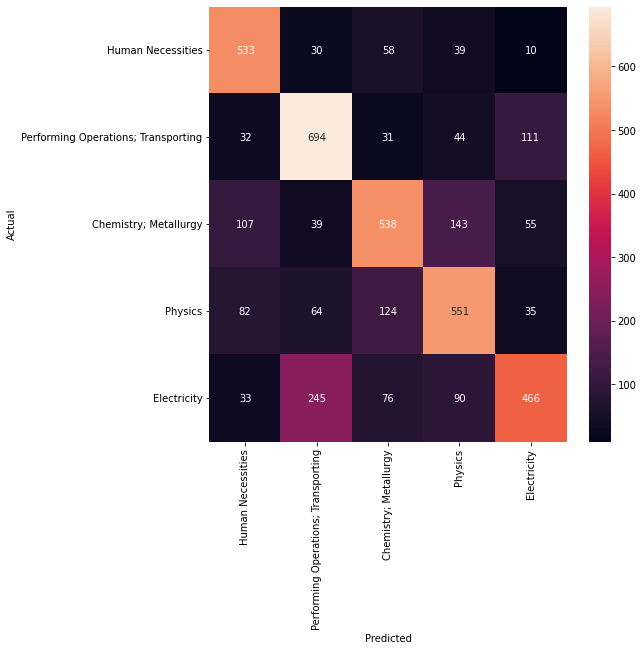

In [ ]:
conf_mat = confusion_matrix(y_test, knn_predictions)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=topics, yticklabels=topics)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Классифицируем текст с помощью метода наивного Байеса

In [ ]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(x_train,y_train)
print('Точность при обучении: ', Naive.score(x_train, y_train))
naive_predictions = Naive.predict(x_test)
print(precision_score(y_test, naive_predictions, average="macro"))
print(recall_score(y_test, naive_predictions, average="macro"))
print(f1_score(y_test, naive_predictions, average="macro"))
print()
print(classification_report(naive_predictions, y_test, target_names=topics))

Точность при обучении:  0.7180505415162455
0.6783849291985845
0.6362307033139472
0.6380866368924334

                                                               precision    recall  f1-score   support

                                            Human Necessities       0.83      0.67      0.74       765
                          Performing Operations; Transporting       0.65      0.72      0.68       804
                                        Chemistry; Metallurgy       0.49      0.81      0.61       559
                                                      Physics       0.43      0.76      0.55       282
                                                  Electricity       0.75      0.52      0.62      1330
Mechanical Engineering; Lightning; Heating; Weapons; Blasting       0.67      0.60      0.63      1009

                                                     accuracy                           0.64      4749
                                                    macro avg       0.64 

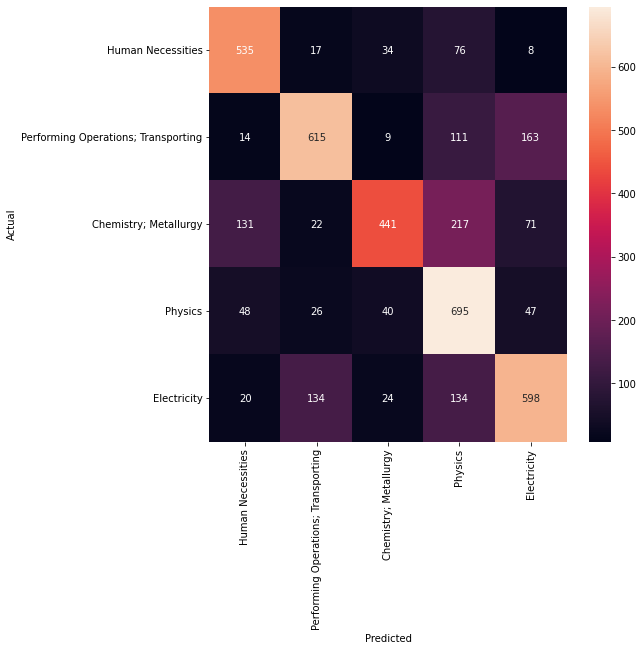

In [ ]:
conf_mat = confusion_matrix(y_test, naive_predictions)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=topics, yticklabels=topics)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()